In [25]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Monterey County Polygon Analysis

## Preparation

In [26]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import contextily as cx
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [27]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}

## Polygon Analysis

Polygon analysis is conducted on a set of worst performing fields based on Mean Absolute Error. This analysis is conducted to see if polygon forecasting is more accurate than point forecasting.

### Historical Import

In [28]:
poly_historical = pd.read_csv('../data/monterey_polygon_large_historical.csv', low_memory=False)
poly_historical['time'] = pd.to_datetime(poly_historical['time'])
poly_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320300 entries, 0 to 320299
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   field_id     320300 non-null  object        
 1   crop         320300 non-null  int64         
 2   time         320300 non-null  datetime64[ns]
 3   actual_et    320300 non-null  float64       
 4   actual_eto   320300 non-null  float64       
 5   actual_etof  320300 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 14.7+ MB


In [29]:
poly_fields = poly_historical['field_id'].unique()

### Forecast Table

In [30]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"../data/forecasts/0.0.1/polygon/monterey/sampled").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823500 entries, 0 to 823499
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   field_id          823500 non-null  object        
 1   crop              823500 non-null  int64         
 2   time              823500 non-null  datetime64[ns]
 3   expected_et       823500 non-null  float64       
 4   expected_eto      823500 non-null  float64       
 5   expected_etof     823500 non-null  float64       
 6   forecasting_date  823500 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 44.0+ MB


### Main Table Compilation

In [31]:
poly_dt = poly_historical.loc[(poly_historical['time'].dt.year == 2024), :]
poly_dt = poly_dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
poly_dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,expected_et,expected_eto,expected_etof
0,2024-09-23,CA_244113,47,2024-01-01,0.383,0.927,0.413,0.383,0.927,0.413
1,2024-09-23,CA_244113,47,2024-01-02,0.315,0.721,0.437,0.315,0.721,0.437
2,2024-09-23,CA_244113,47,2024-01-03,0.664,1.442,0.461,0.664,1.442,0.461
3,2024-09-23,CA_244113,47,2024-01-04,0.838,1.853,0.452,0.838,1.853,0.452
4,2024-09-23,CA_244113,47,2024-01-05,0.502,1.133,0.443,0.502,1.133,0.443
...,...,...,...,...,...,...,...,...,...,...
823495,2024-01-29,CA_257924,47,2024-12-27,NaN,NaN,NaN,0.523,1.531,0.822
823496,2024-01-29,CA_257924,47,2024-12-28,NaN,NaN,NaN,0.520,1.420,0.819
823497,2024-01-29,CA_257924,47,2024-12-29,NaN,NaN,NaN,0.540,1.293,0.818
823498,2024-01-29,CA_257924,47,2024-12-30,NaN,NaN,NaN,0.566,1.228,0.809


## Reference Tables

### Add USDA crop data

In [32]:
# Add crop data
cdl_codes = pd.read_csv("../data/cdl_codes.csv", low_memory=False).set_index("Codes")

### Average ET/ETo/ETof for 2024

In [34]:
poly_avgs = poly_dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean').reset_index()
poly_avgs.head()

,field_id,crop,actual_et,actual_eto,actual_etof
0,CA_244113,47,1.257199,5.412463,0.341740
1,CA_244148,69,4.102858,4.695402,0.894897
2,CA_244387,61,2.028206,3.648089,0.653612
3,CA_244429,47,3.394868,4.345655,0.844996
4,CA_244437,47,3.724135,4.668032,0.876904


### Climatology Reference

In [35]:
# Create a column for day of year
poly_historical['doy'] = poly_historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
poly_climatology = poly_historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean').reset_index()
poly_climatology

,field_id,crop,doy,actual_et,actual_eto,actual_etof
0,CA_244113,47,1,0.459333,0.915556,0.532778
1,CA_244113,47,2,0.572778,1.075778,0.536667
2,CA_244113,47,3,0.713889,1.293000,0.540556
3,CA_244113,47,4,0.717556,1.384333,0.540889
4,CA_244113,47,5,0.619333,1.247222,0.546556
...,...,...,...,...,...,...
36595,CA_257924,47,362,0.898500,1.020875,0.863000
36596,CA_257924,47,363,0.921375,1.109500,0.826000
36597,CA_257924,47,364,0.800125,0.965375,0.836625
36598,CA_257924,47,365,0.684875,0.798750,0.847250


## Accuracy Metric Calculation

In [36]:
analysis_end_date = poly_historical['time'].max()

In [37]:
poly_metrics = (poly_dt[(poly_dt['time'] > poly_dt['forecasting_date']) & (poly_dt['time'] < (poly_dt['forecasting_date']) + timedelta(days=7)) & (poly_dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date'])[list(poly_dt.columns)]
                .apply(eval_metrics, normalize=True, climatology_ref=poly_climatology, avgs_ref=poly_avgs))
poly_metrics.reset_index().to_csv('../data/metrics/monterey_poly_metrics.csv', index=False)

/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib

In [38]:
poly_metrics = pd.read_csv('../data/metrics/monterey_poly_metrics.csv').drop(['level_1'], axis=1)
poly_metrics['forecasting_date'] = pd.to_datetime(poly_metrics['forecasting_date'])

### Visualization

In [39]:
# First reshape data from wide-form to long-form
poly_metrics_long = poly_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
poly_metrics_long['name'] = poly_metrics_long['stat'].map(stat_propers)

#### Interquartile Metrics

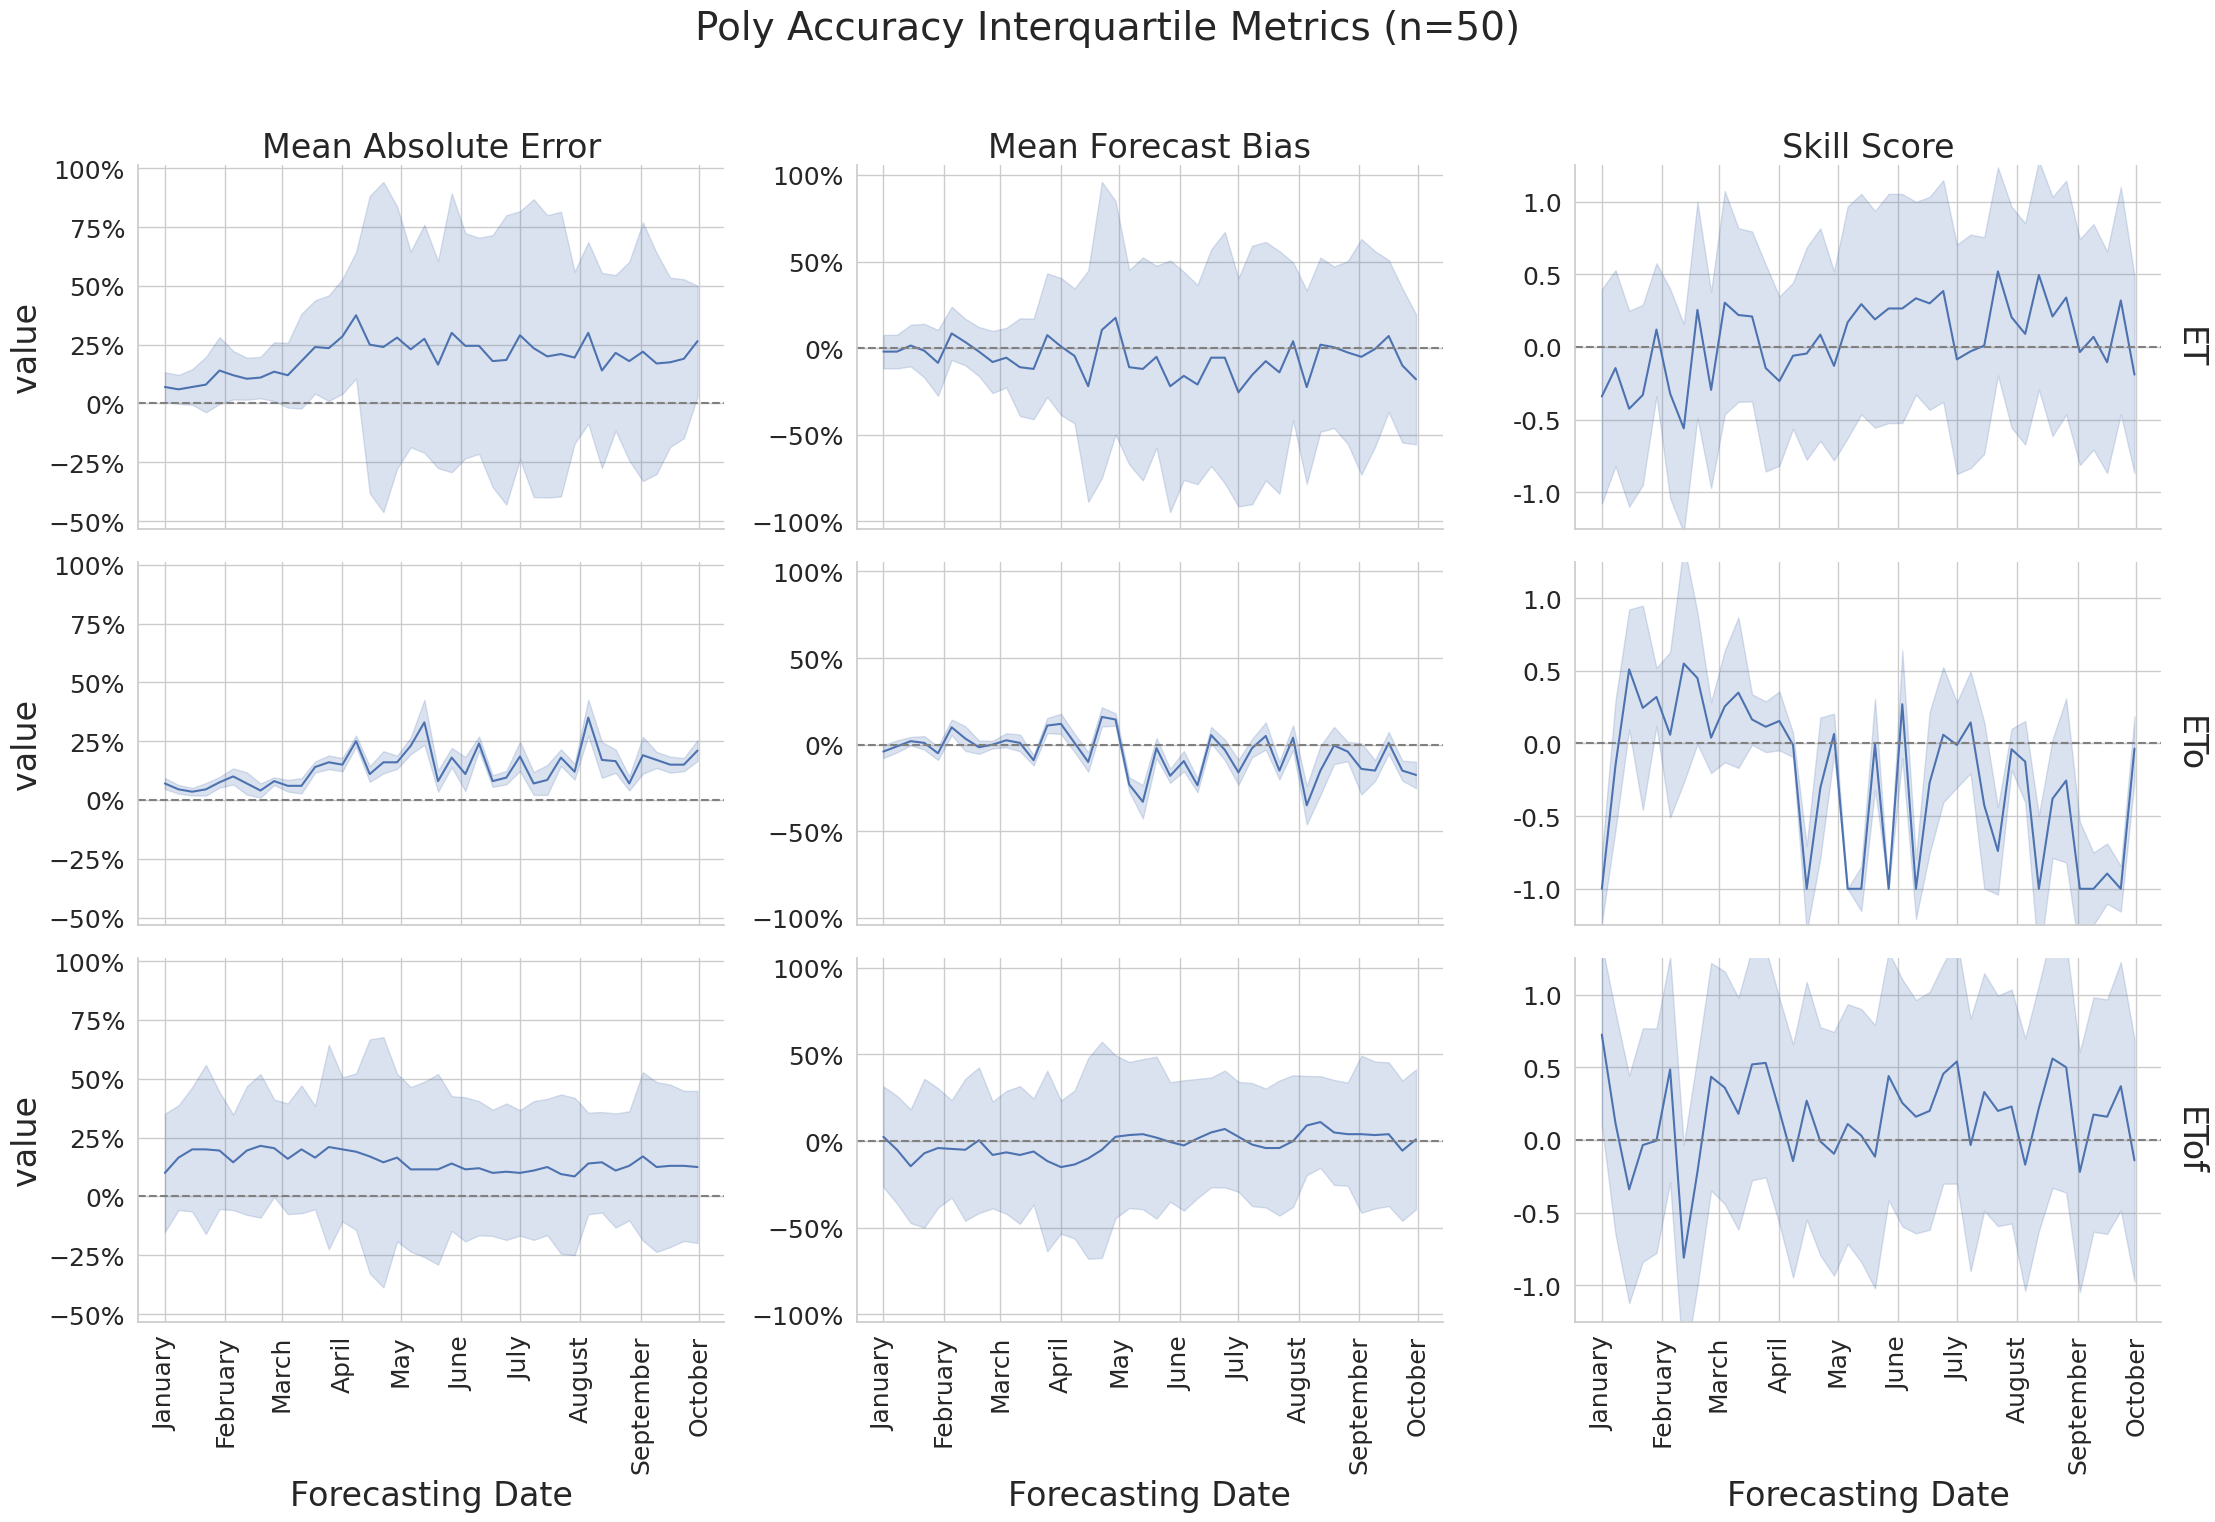

In [40]:
rel = timeseries_rel(poly_metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Poly Accuracy Interquartile Metrics (n=50)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/monterey/poly_field_metric_range_sd.png')

#### Point vs Polygon Comparison

A comparison is made against the same fields specified by the Polygon table.

In [41]:
point_metrics = pd.read_csv('../data/metrics/monterey_metrics_normalized.csv', low_memory=False).drop(columns='level_1')
point_metrics['forecasting_date'] = pd.to_datetime(point_metrics['forecasting_date'])
point_metrics_long = point_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

point_metrics_long['name'] = point_metrics_long['stat'].map(stat_propers)
point_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259389 entries, 0 to 259388
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  259389 non-null  datetime64[ns]
 1   field_id          259389 non-null  object        
 2   crop              259389 non-null  int64         
 3   variable          259389 non-null  object        
 4   stat              259389 non-null  object        
 5   value             259389 non-null  float64       
 6   name              259389 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 13.9+ MB


In [42]:
point_cmp_metrics = point_metrics_long[point_metrics_long['field_id'].isin(poly_fields)]

In [43]:
point_cmp_metrics.loc[:, 'shape'] = 'point'
poly_metrics_long['shape'] = 'polygon'

shape_metrics_long = pd.concat([point_cmp_metrics, poly_metrics_long])
shape_metrics_long = shape_metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

/tmp/ipykernel_4101305/849047582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_cmp_metrics.loc[:, 'shape'] = 'point'


##### Interquartile Comparison

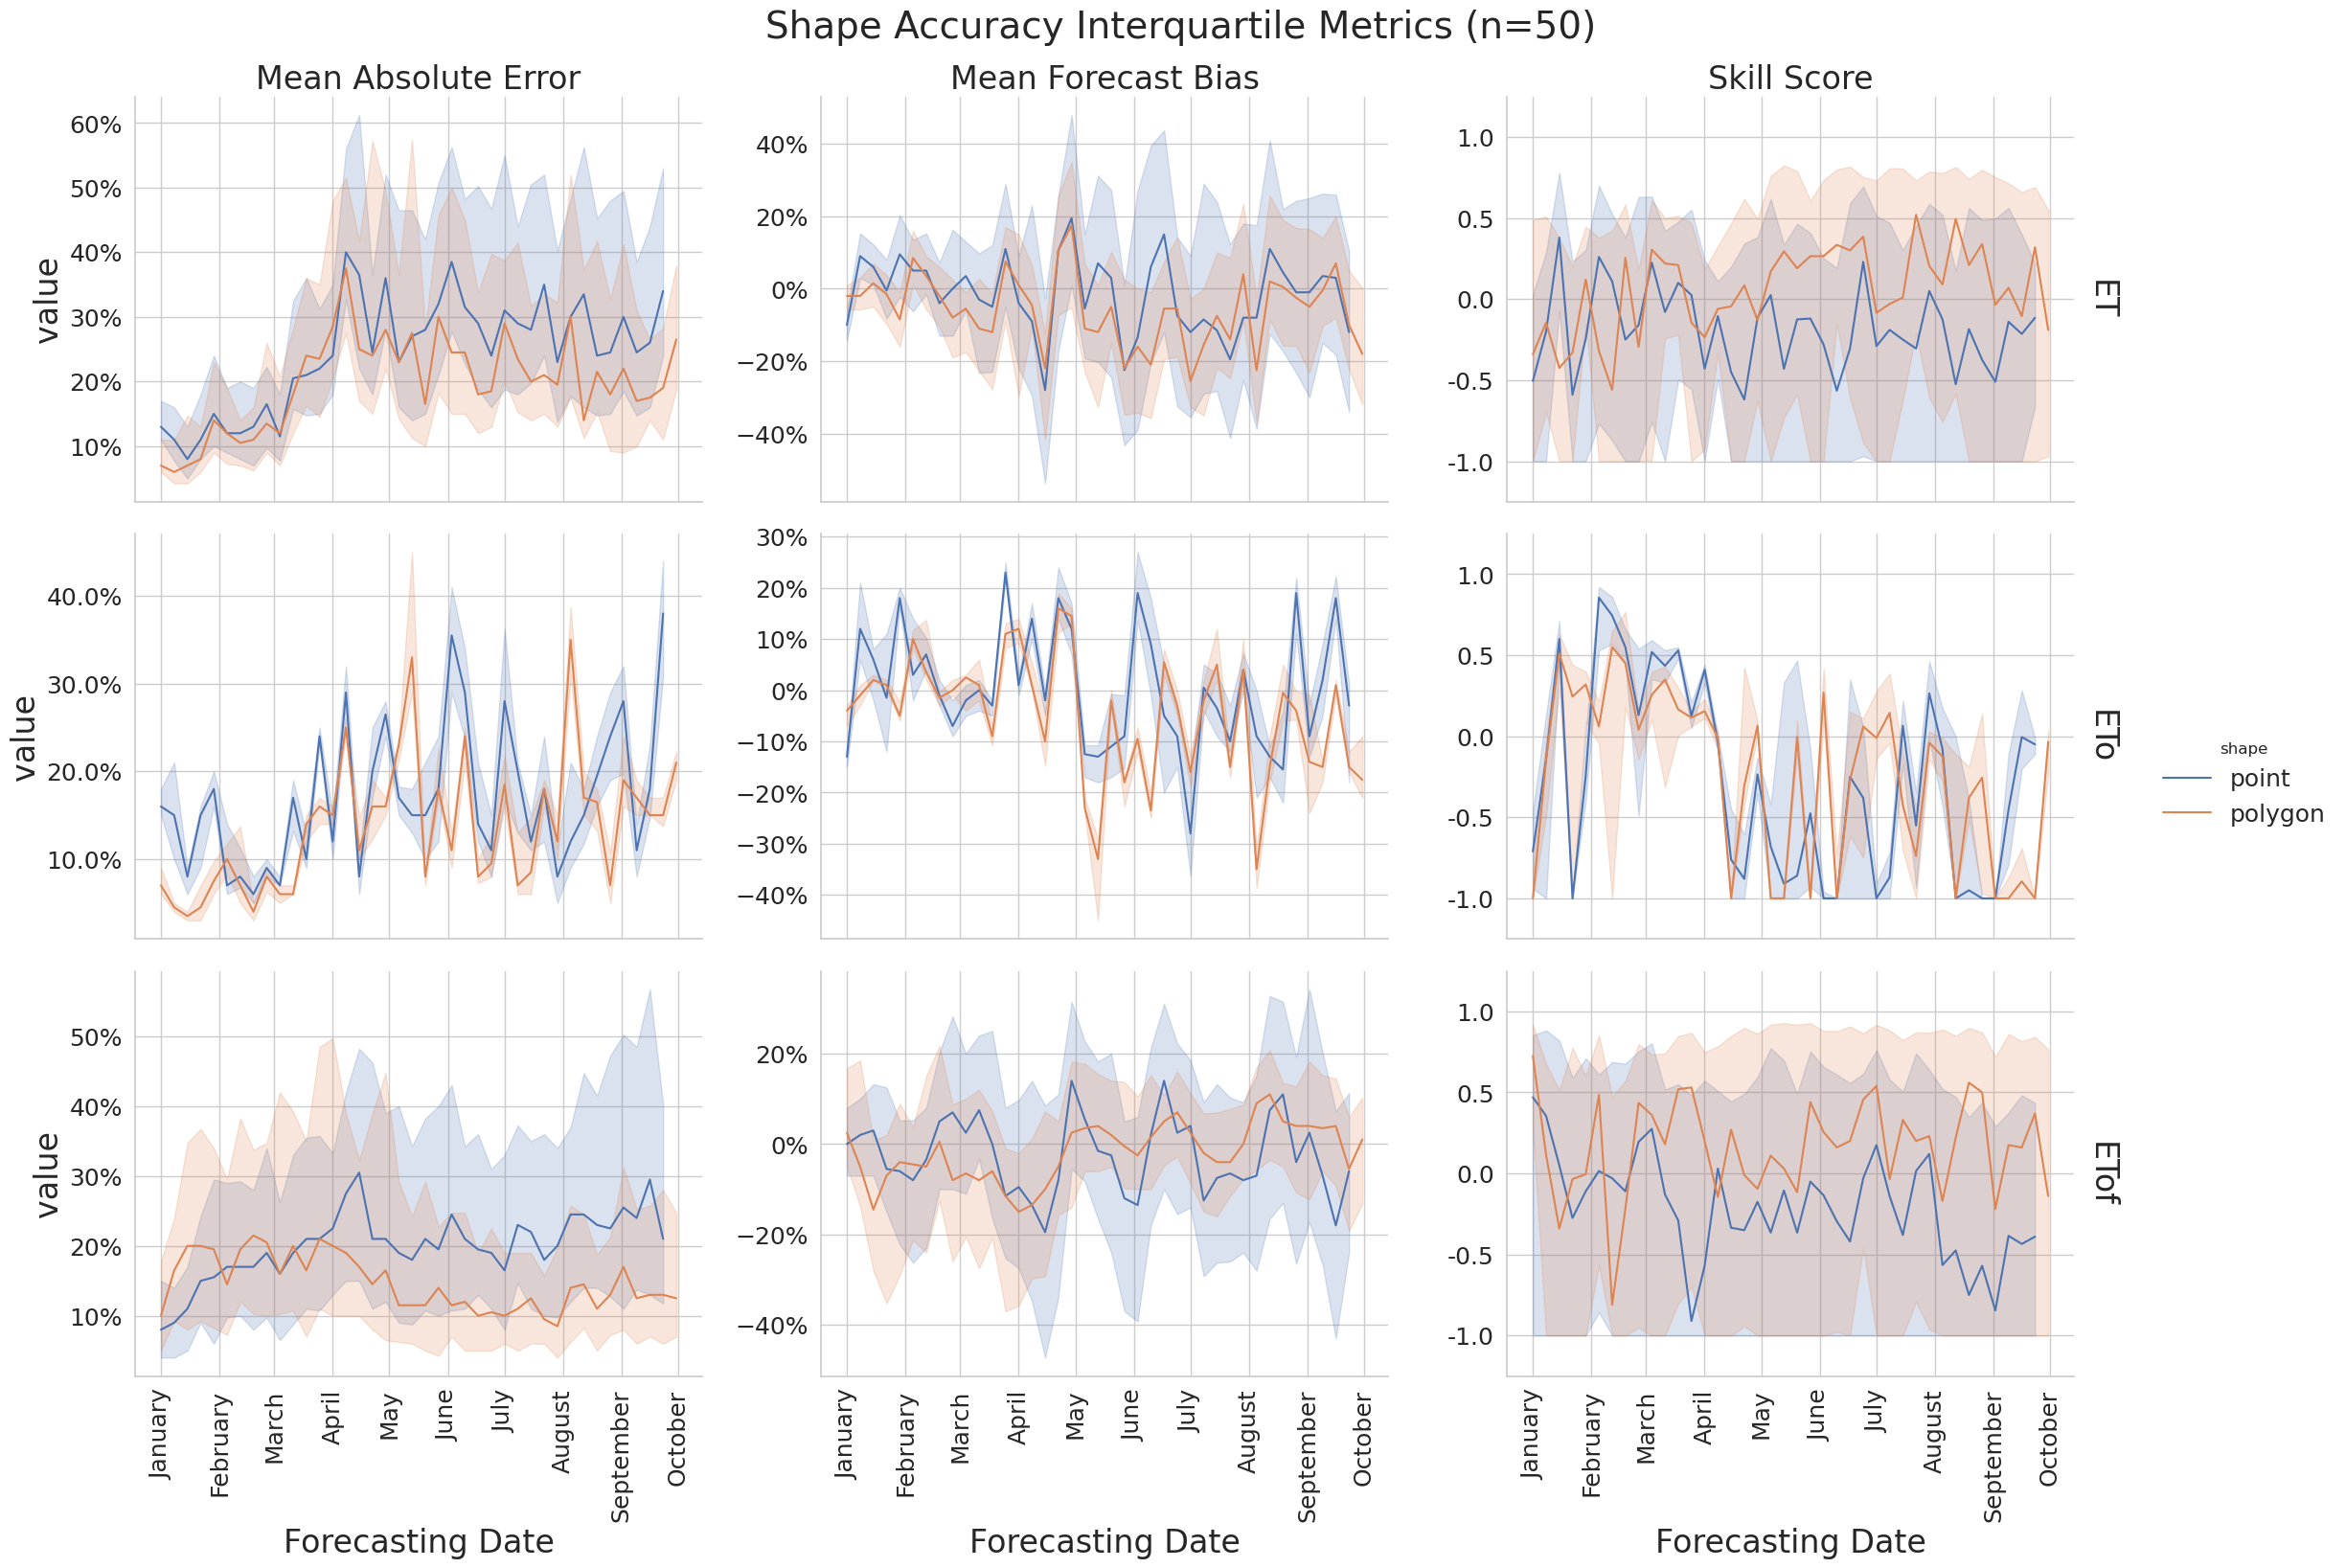

In [44]:
rel = timeseries_rel(shape_metrics_long, row='variable', col='name', y='value', hue='shape',
                     errorbar=("pi", 50), estimator=np.median, as_percent=True,
                     # refline={'y': 0},
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Shape Accuracy Interquartile Metrics (n=50)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/monterey/shape_comparison.png')

# Crop Comparison

In [45]:
crop_selector = [47, 69]
shape_crop_plotter = shape_metrics_long[shape_metrics_long['crop'].isin(crop_selector)]
shape_crop_plotter.head()

,forecasting_date,field_id,crop,variable,stat,value,name,shape,Class_Names,ESRI_Red,ESRI_Green,ESRI_Blue,Erdas_Red,Erdas_Green,Erdas_Blue
10,2024-01-01,CA_244113,47,ETof,mae,0.04,Mean Absolute Error,point,Misc Vegs & Fruits,255,102,102,1.0000,0.4000,0.4000
12,2024-01-01,CA_244148,69,ETof,mae,0.02,Mean Absolute Error,point,Grapes,112,68,137,0.4392,0.2667,0.5373
30,2024-01-01,CA_244429,47,ETof,mae,0.08,Mean Absolute Error,point,Misc Vegs & Fruits,255,102,102,1.0000,0.4000,0.4000
31,2024-01-01,CA_244437,47,ETof,mae,0.14,Mean Absolute Error,point,Misc Vegs & Fruits,255,102,102,1.0000,0.4000,0.4000
34,2024-01-01,CA_244479,47,ETof,mae,0.03,Mean Absolute Error,point,Misc Vegs & Fruits,255,102,102,1.0000,0.4000,0.4000


In [46]:
shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')

/tmp/ipykernel_4101305/1161630914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')


/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


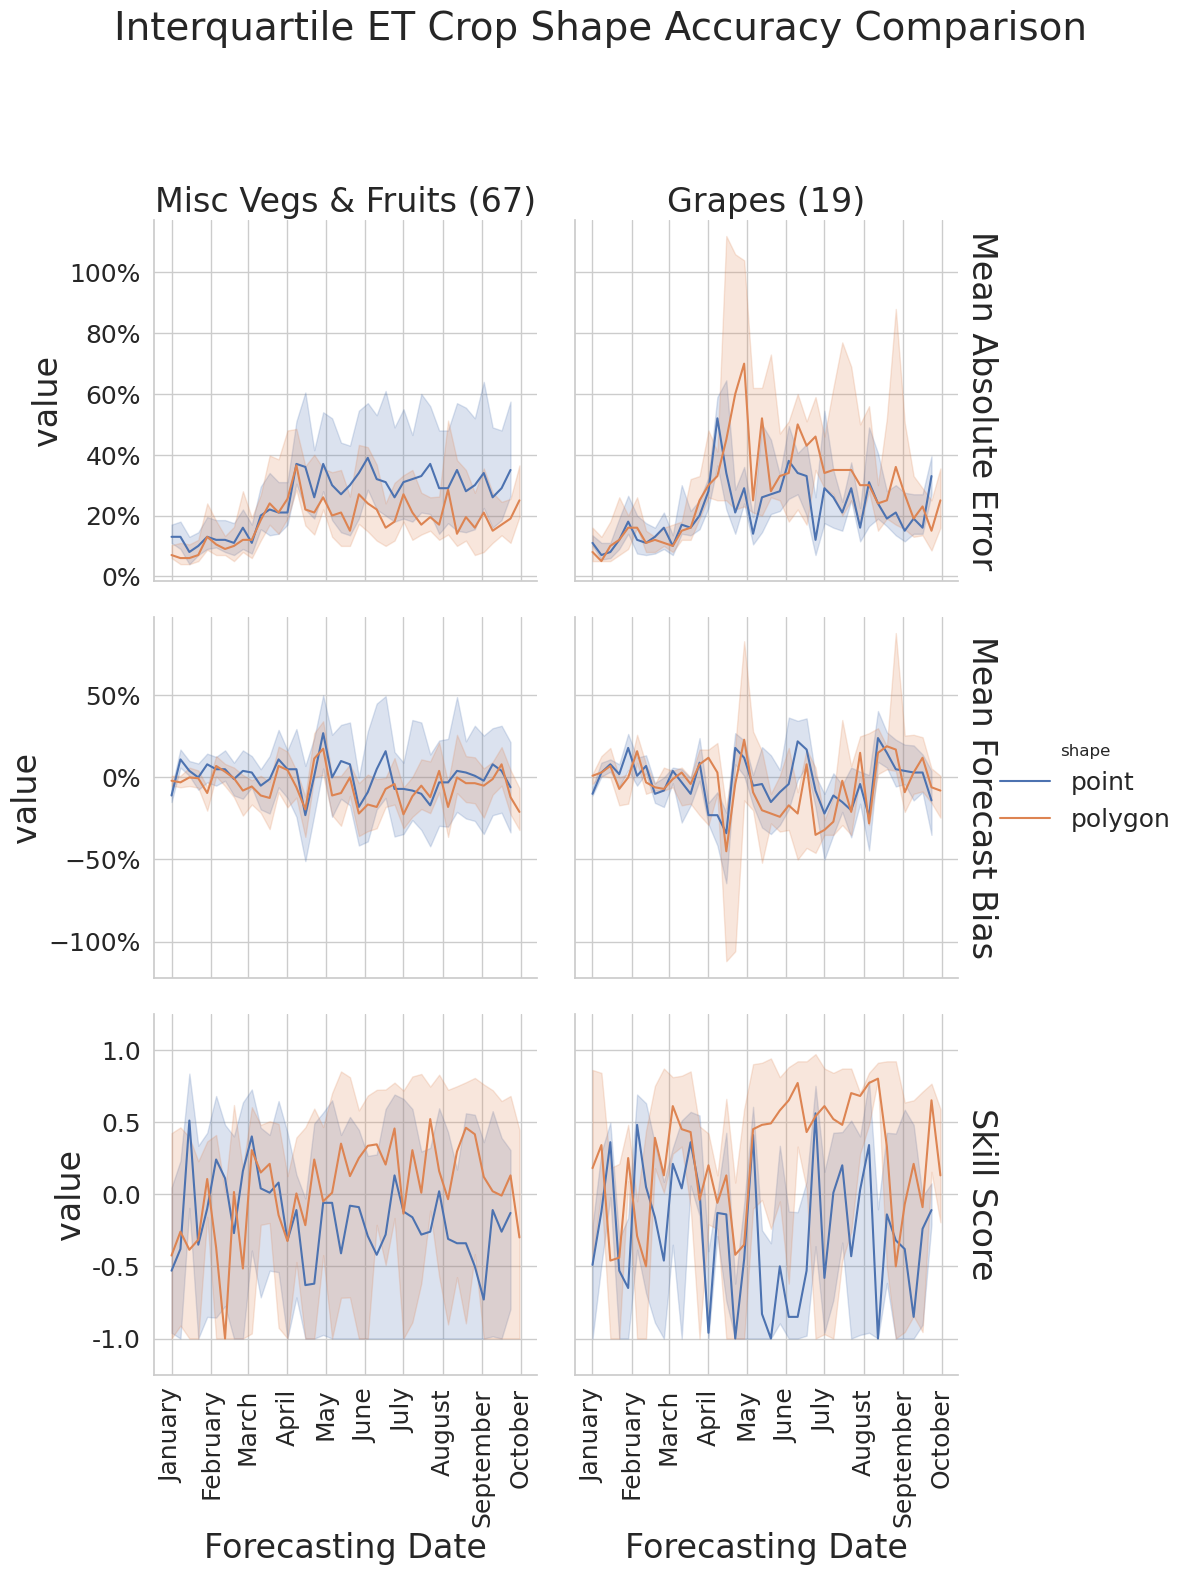

In [47]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ET Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/monterey/et_crop_shape_compare.png");

/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


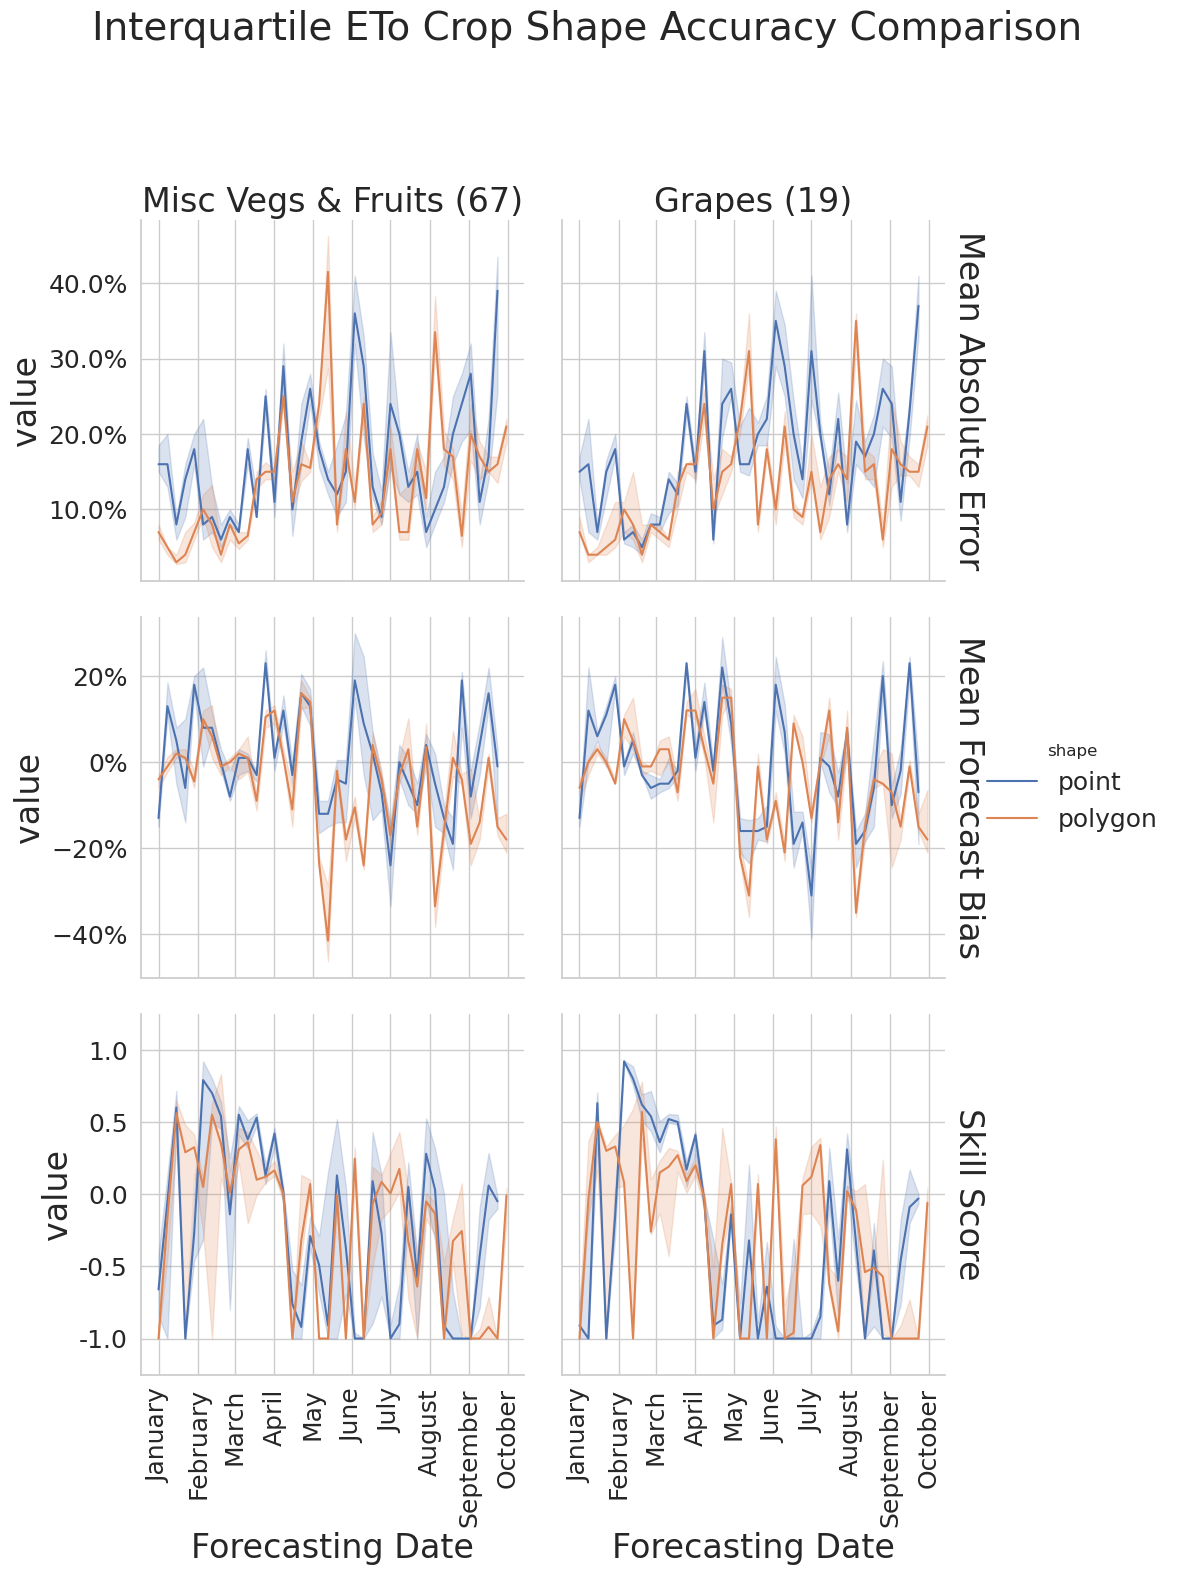

In [48]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETo Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/monterey/eto_crop_shape_compare.png")

/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


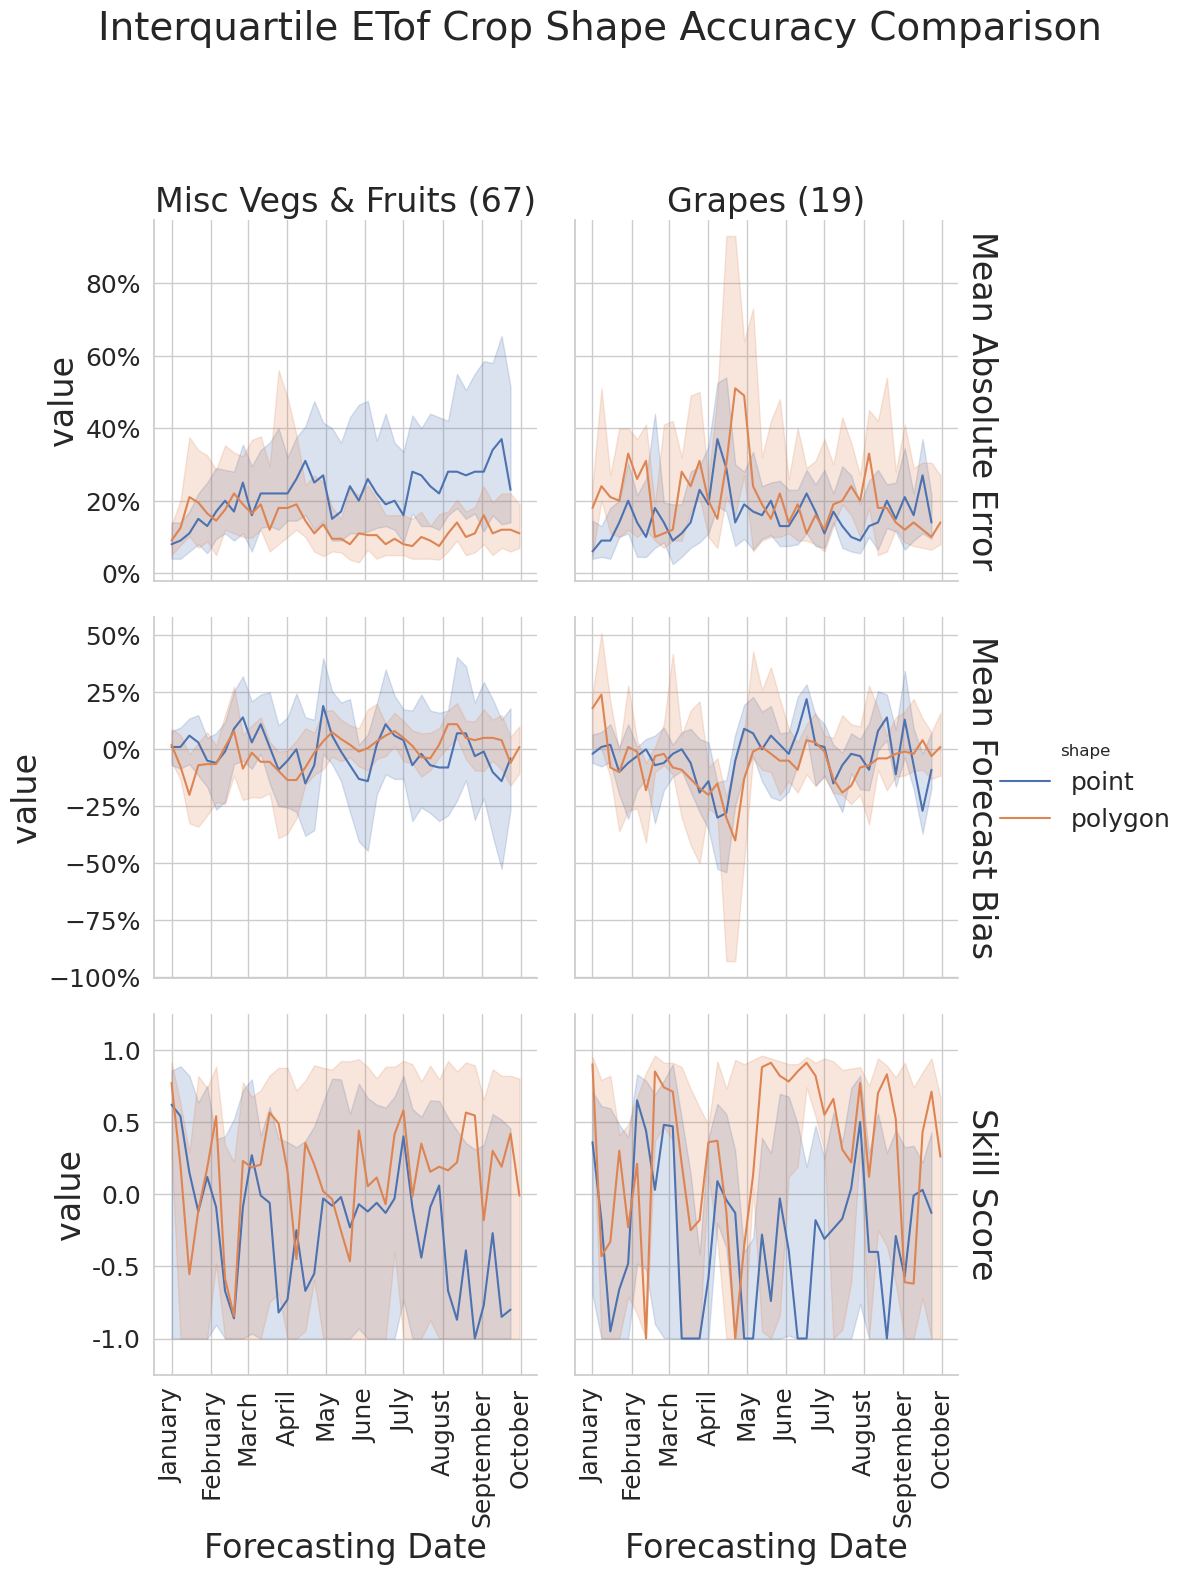

In [49]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETof Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/monterey/etof_crop_shape_compare.png")